In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [49]:
import os
from PIL import Image
from IPython.display import display

In [50]:
import warnings 
warnings.filterwarnings('ignore')

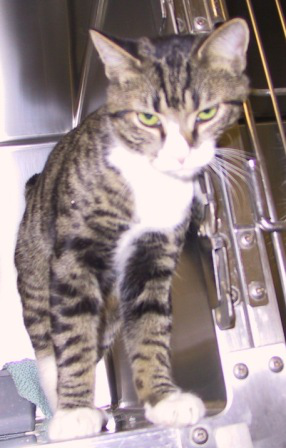

In [51]:
with Image.open('./CATS_DOGS/test/CAT/10110.jpg') as im:
    display(im)

In [52]:
path ='./CATS_DOGS/'
img_names = []

for folder,subfolder ,filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder + '/' + img)

In [53]:
len(img_names)

24994

In [54]:
img_sizes = []
rejected  = []

for item in img_names:
    
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    
    except:
        rejected.append(img)

In [55]:
print(len(img_sizes))
print(len(rejected))

24994
0


In [56]:
df = pd.DataFrame(img_sizes)

In [57]:
df[0].describe()

count    24994.000000
mean       404.493518
std        108.941802
min         42.000000
25%        323.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: 0, dtype: float64

In [58]:
df[1].describe()

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: 1, dtype: float64

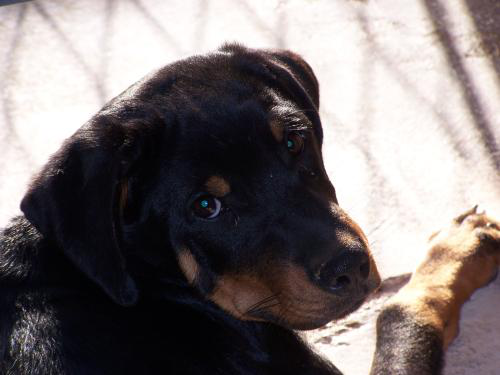

In [59]:
with Image.open('./CATS_DOGS/train/DOG/15.jpg') as dog:
    display(dog)

In [60]:
dog.size

(500, 375)

In [61]:
dog.getpixel((200,150))

(7, 6, 11)

In [62]:
transform = transforms.Compose([
    transforms.ToTensor()
])

im = transform(dog)
print(im.shape)
print(type(im))

torch.Size([3, 375, 500])
<class 'torch.Tensor'>


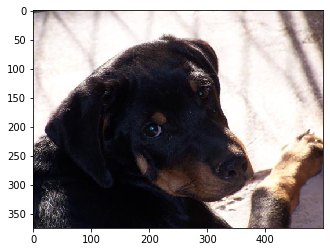

In [63]:
plt.imshow(im.permute(1,2,0))

In [64]:
im[:,0,0]

tensor([0.2157, 0.2353, 0.3608])

In [65]:
transform = transforms.Compose([
    transforms.Resize((350,350)),
    transforms.CenterCrop(350),
    transforms.ToTensor()
])

im = transform(dog)

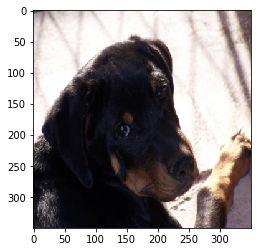

In [66]:
plt.imshow(im.permute(1,2,0))

In [67]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

im = transform(dog)

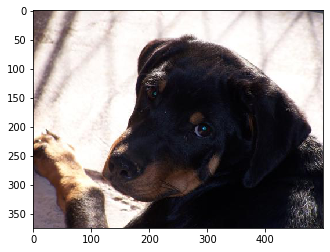

In [68]:
plt.imshow(im.permute(1,2,0))

In [69]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

im = transform(dog)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


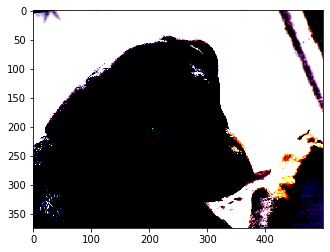

In [70]:
plt.imshow(im.permute(1,2,0))

In [71]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [72]:
test_transform = transforms.Compose([
     transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [73]:
root = './CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(root,'train'),transform=train_transform)

test_data = datasets.ImageFolder(os.path.join(root,'test'),transform=test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data,batch_size=10,shuffle = True)
test_loader = DataLoader(test_data,batch_size= 10)

In [74]:
class_names = train_data.classes

In [75]:
class_names

['CAT', 'DOG']

In [76]:
len(train_data)

18743

In [77]:
len(test_data)

6251

In [78]:
for images,labels in train_loader:
    break

In [79]:
images.shape

torch.Size([10, 3, 224, 224])

In [80]:
from torchvision.utils import make_grid

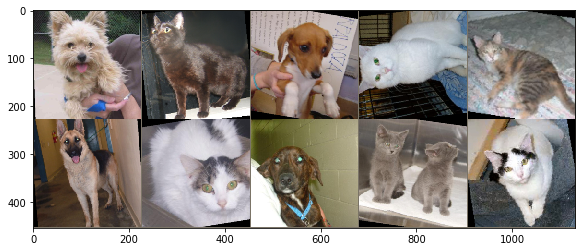

In [81]:
im = make_grid(images, nrow = 5)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(im_inv.permute(1,2,0))

In [86]:
class ConvolutionalNet(nn.Module):
    
    def  __init__(self):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,12,3,1)
        self.conv2 = nn.Conv2d(12,20,3,1)
        self.fc1 = nn.Linear(54*54*20,170)
        self.fc2 = nn.Linear(170,80)
        self.fc3 = nn.Linear(80,2)
        
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*20)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)
        

In [90]:
torch.manual_seed(101)
model = ConvolutionalNet()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [91]:
model

ConvolutionalNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=58320, out_features=170, bias=True)
  (fc2): Linear(in_features=170, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)

In [92]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.62281042  accuracy:  59.300%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.68843985  accuracy:  60.500%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.57356930  accuracy:  62.067%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.61494452  accuracy:  63.038%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.67131948  accuracy:  67.250%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.71609282  accuracy:  68.450%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.47489986  accuracy:  69.317%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.91277617  accuracy:  69.188%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.68362200  accuracy:  72.350%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.48271528  accuracy:  72.550%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.42918974  accuracy:  72.650%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.44626617  accuracy:  72.925%

Duration: 1357 seconds


In [93]:
torch.save(model.state_dict(), 'CustomImageCNNModel.pt')

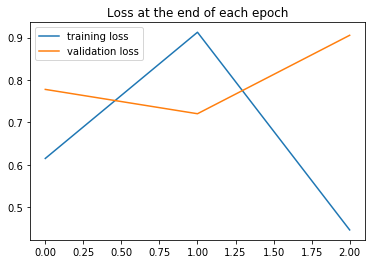

In [94]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

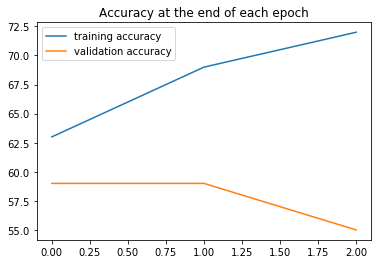

In [95]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [96]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(1772), tensor(1786), tensor(1658)]
Test accuracy: 55.267%


In [97]:
ALEXnetmodel = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/avinash/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:46<00:00, 5.29MB/s] 


In [98]:
ALEXnetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [99]:
for param in ALEXnetmodel.parameters():
    param.requires_grad = False

In [101]:
torch.manual_seed(42)

ALEXnetmodel.classifier = nn.Sequential(nn.Linear(9216,1024),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Linear(1024,2),
                                       nn.LogSoftmax(dim = 1))

In [102]:
ALEXnetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [103]:
optimizer = torch.optim.Adam(ALEXnetmodel.classifier.parameters())
criterion = nn.CrossEntropyLoss()

In [104]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = ALEXnetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = ALEXnetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 1.07194269  accuracy:  88.050%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.00945045  accuracy:  90.850%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.67100257  accuracy:  91.733%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.15630811  accuracy:  91.925%

Duration: 449 seconds


In [106]:
print(test_correct[-1].item()/3000)

0.859


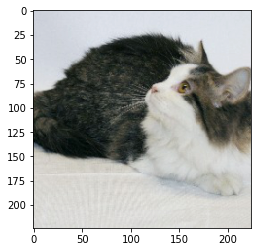

In [112]:
image_index = 2019

im = inv_normalize(test_data[image_index][0])
plt.imshow(im.permute(1,2,0))

In [117]:
model.eval()

with torch.no_grad():
    
    new_pred = model(test_data[image_index][0].view(1,3,224,224)).argmax()

In [119]:
class_names[new_pred.item()]

'CAT'

In [120]:
ALEXnetmodel.eval()

with torch.no_grad():
    
    new_pred = ALEXnetmodel(test_data[image_index][0].view(1,3,224,224)).argmax()

In [121]:
class_names[new_pred.item()]

'CAT'

In [ ]:
s